In [ ]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90
=========

모델성능
N_HIDDENS = 100 # perceptron수
N_LAYERS = 3 # 레이어 층수 
BATCH_SIZE = 512 # computing 속도.

n_epochs=40

early stop
learningrate 조절
====

평가성능
THRESHOLD = 0.060
 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
# 최종 Evaluate Package 설치
!pip install ./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl

Processing ./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/eTaPR-21.8.2-py3-none-any.whl


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import torch
from torch.utils.data import Dataset, DataLoader



from keras.models import Model, Sequential, load_model
import keras
from keras import optimizers
from keras.layers import Input,Bidirectional ,LSTM, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

from pathlib import Path
from datetime import timedelta
import dateutil
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [ ]:
# !pip freeze > ./gdrive/MyDrive/멋사_study/HAICon2021/requirements.txt

In [5]:
# Data Path Load
path_train = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/train").glob("*.csv")]) 
path_test = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/test").glob("*.csv")]) 
path_validation = sorted([x for x in Path("./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/validation").glob("*.csv")]) 

In [20]:
def csv_to_df(target):
    return pd.read_csv(target)

def df_data_load(targets):
    return pd.concat([csv_to_df(x) for x in targets])

# Min-Max Regularization
def normalize(raw):
    ndf = raw.copy()
    for c in raw.columns:
        #min-max가 0인경우에는 무의미한 col으로 생각하고, 0으로 채워줌
        if raw_train[useful_cols].min()[c] == raw_train[useful_cols].max()[c]:
            ndf[c] = raw[c] - raw_train[useful_cols].min()[c]
        else:
            ndf[c] = (raw[c] - raw_train[useful_cols].min()[c]) / (raw_train[useful_cols].max()[c] - raw_train[useful_cols].min()[c])
    return ndf

In [7]:
raw_train = df_data_load(path_train) # timestamp,C01~C86
raw_validation = df_data_load(path_validation) # timestamp,C01~C86, attack
raw_test = df_data_load(path_test) # timestamp,C01~C86

# time stamp는 attack event와 관련이 없는 관계로 삭제한다.
# time stamp는 normalize 시에 에러 발생

useful_cols = raw_train.columns.drop('timestamp')
useful_cols

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

z-score vs min-max algorithm <br>
outlier검출 (z-score) <br>
모든 데이터의 중요도를 동일하게(min-max)

In [27]:
# Exponential Weighted Function 통과
# 센서에서 발생하는 noise를 **smoothing** 시켜주기 위해 적용
df_train= normalize(raw_train[useful_cols]).ewm(alpha=0.9).mean()

In [9]:
# min_max reg를 진행하고, boundary인 [0,1] 이외의 값이 존재하는지 체크하는 함수
# Reguralizaion 제대로 됐는지 체크
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [28]:
boundary_check(df_train)

(False, False, False)

In [48]:
df_validation = normalize(raw_validation[useful_cols])

In [47]:
df_test= normalize(raw_test[useful_cols]).ewm(alpha=0.9).mean()

In [49]:
# df_train.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_train.pickle")
# df_validation.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_validation.pickle")
# df_test.to_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_test.pickle")

# normalize 완료된 df 불러오기

In [ ]:
# normalize 완료된 df 불러오기
df_train = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_train.pickle")
df_validation = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_validation.pickle")
df_test = pd.read_pickle("/content/gdrive/MyDrive/멋사_study/HAICon2021/df_test.pickle")


In [29]:
# Model의 출력값과 실제 값의 차이가 클 때 이상상황으로 정의
# Stacked RNN(GRU cells)
# Unsupervised Learning
# shingle size = 90

WINDOW_GIVEN = 39
WINDOW_SIZE = 40



class HaiDataset(Dataset): # pytorch의 Dataset class 활용
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + stride):
            R = L + WINDOW_SIZE - stride
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - stride):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx): ## slicing을 구현하기 위한 메소드
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [30]:
train_data = HaiDataset(raw_train['timestamp'],df_train, stride=1)

  0%|          | 0/1004363 [00:00<?, ?it/s]

# of valid windows: 1004168


# HaiDataset 저장/불러오기

In [155]:
import pickle
# # HaiDataset 저장
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/train_data", "wb" ) as file:
#     pickle.dump( train_data, file)
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/validation_data", "wb" ) as file:
#     pickle.dump( validation_data, file)
# with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/test_data", "wb" ) as file:
#     pickle.dump( test_data, file)

# HaiDataset 불러오기
with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/train_data", "rb" ) as file:
    train_data = pickle.load(file)

with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/validation_data", "rb" ) as file:
    validation_data = pickle.load(file)

with open( "/content/gdrive/MyDrive/멋사_study/HAICon2021/test_data", "rb" ) as file:
    test_data = pickle.load(file)

## 모델링 시작

In [32]:
N_HIDDENS = 100 # perceptron수
N_LAYERS = 3
BATCH_SIZE = 512

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__() # torch.nn.Module에 담겨있는 함수를 사용하겠다.
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,# perceptron수
            num_layers=N_LAYERS,
            bidirectional=True, #양방향으로 할지 말지 forward + backward 두번씩 하니까 feature가 두배로 변함
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [33]:
MODEL = StackedGRU(n_tags=df_train.shape[1]) # input사이즈를 train data columns수로 하겠다는뜻
MODEL.cuda() # GPU 메모리 할당

StackedGRU(
  (rnn): GRU(86, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=86, bias=True)
)

In [26]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # Dataloader는 Mini Batch만들어 주는 역할. # 전체 데이터가 mini batch Size로 슬라이스됨. 
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [16]:
import sys

In [17]:
%%time
n_epochs = 40
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(train_data, MODEL, BATCH_SIZE,n_epochs=n_epochs)

training:   0%|          | 0/40 [00:00<?, ?it/s]

CPU times: user 1h 59min 2s, sys: 36.2 s, total: 1h 59min 38s
Wall time: 1h 59min 30s


### 모델저장 , 불러오기

In [19]:
with open("/content/gdrive/MyDrive/멋사_study/HAICon2021/model_W{}_B{}_P{}_D{}_E{}.pt".format(WINDOW_SIZE,BATCHSIZE,N_HIDDENS,N_LAYERS,n_epochs), "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [51]:
with open("/content/gdrive/MyDrive/멋사_study/HAICon2021/model_W40_P100_D340.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

# 변수명 SAVED_MODEL

<All keys matched successfully>

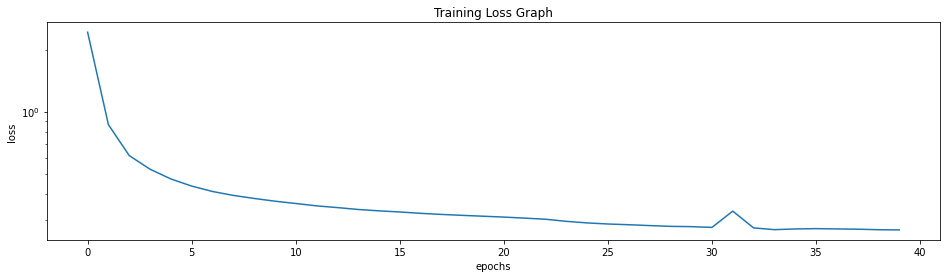

In [56]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [57]:
boundary_check(df_validation) # VAL data에는 아무래도 attack 이 있었기 때문에 TRUE가 발생해야됨

(True, True, False)

In [58]:
validation_data = HaiDataset(raw_validation['timestamp'], df_validation, stride=1)

  0%|          | 0/86361 [00:00<?, ?it/s]

# of valid windows: 86361


In [59]:
def inference(dataset, model, batch_size): # ????????????????????????????????????
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy()) # 예측값과 정답값의 차이를 기록
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )
   

In [99]:
%%time
MODEL.eval() # nn.Module에서 train time과 eval time에서 수행하는 다른 작업을 수행할 수 있도록 switching 하는 함수라고 한다.
valid_CHECK_TS, valid_CHECK_DIST, valid_CHECK_ATT = inference(validation_data, MODEL, BATCH_SIZE)
# CHECK_DIST = 모든 시간대에서 전체 feature(field) 차이

CPU times: user 5.41 s, sys: 32.4 ms, total: 5.45 s
Wall time: 5.44 s


In [102]:
valid_ANOMALY_SCORE = np.mean(valid_CHECK_DIST, axis=1)
# 그 차이의 평균을 스코어 지수로 표현

In [62]:
def check_graph(xs, att, piece=2, THRESHOLD=None):# plot은 몇개 plot으로 그림 그려줄지 정하는거
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

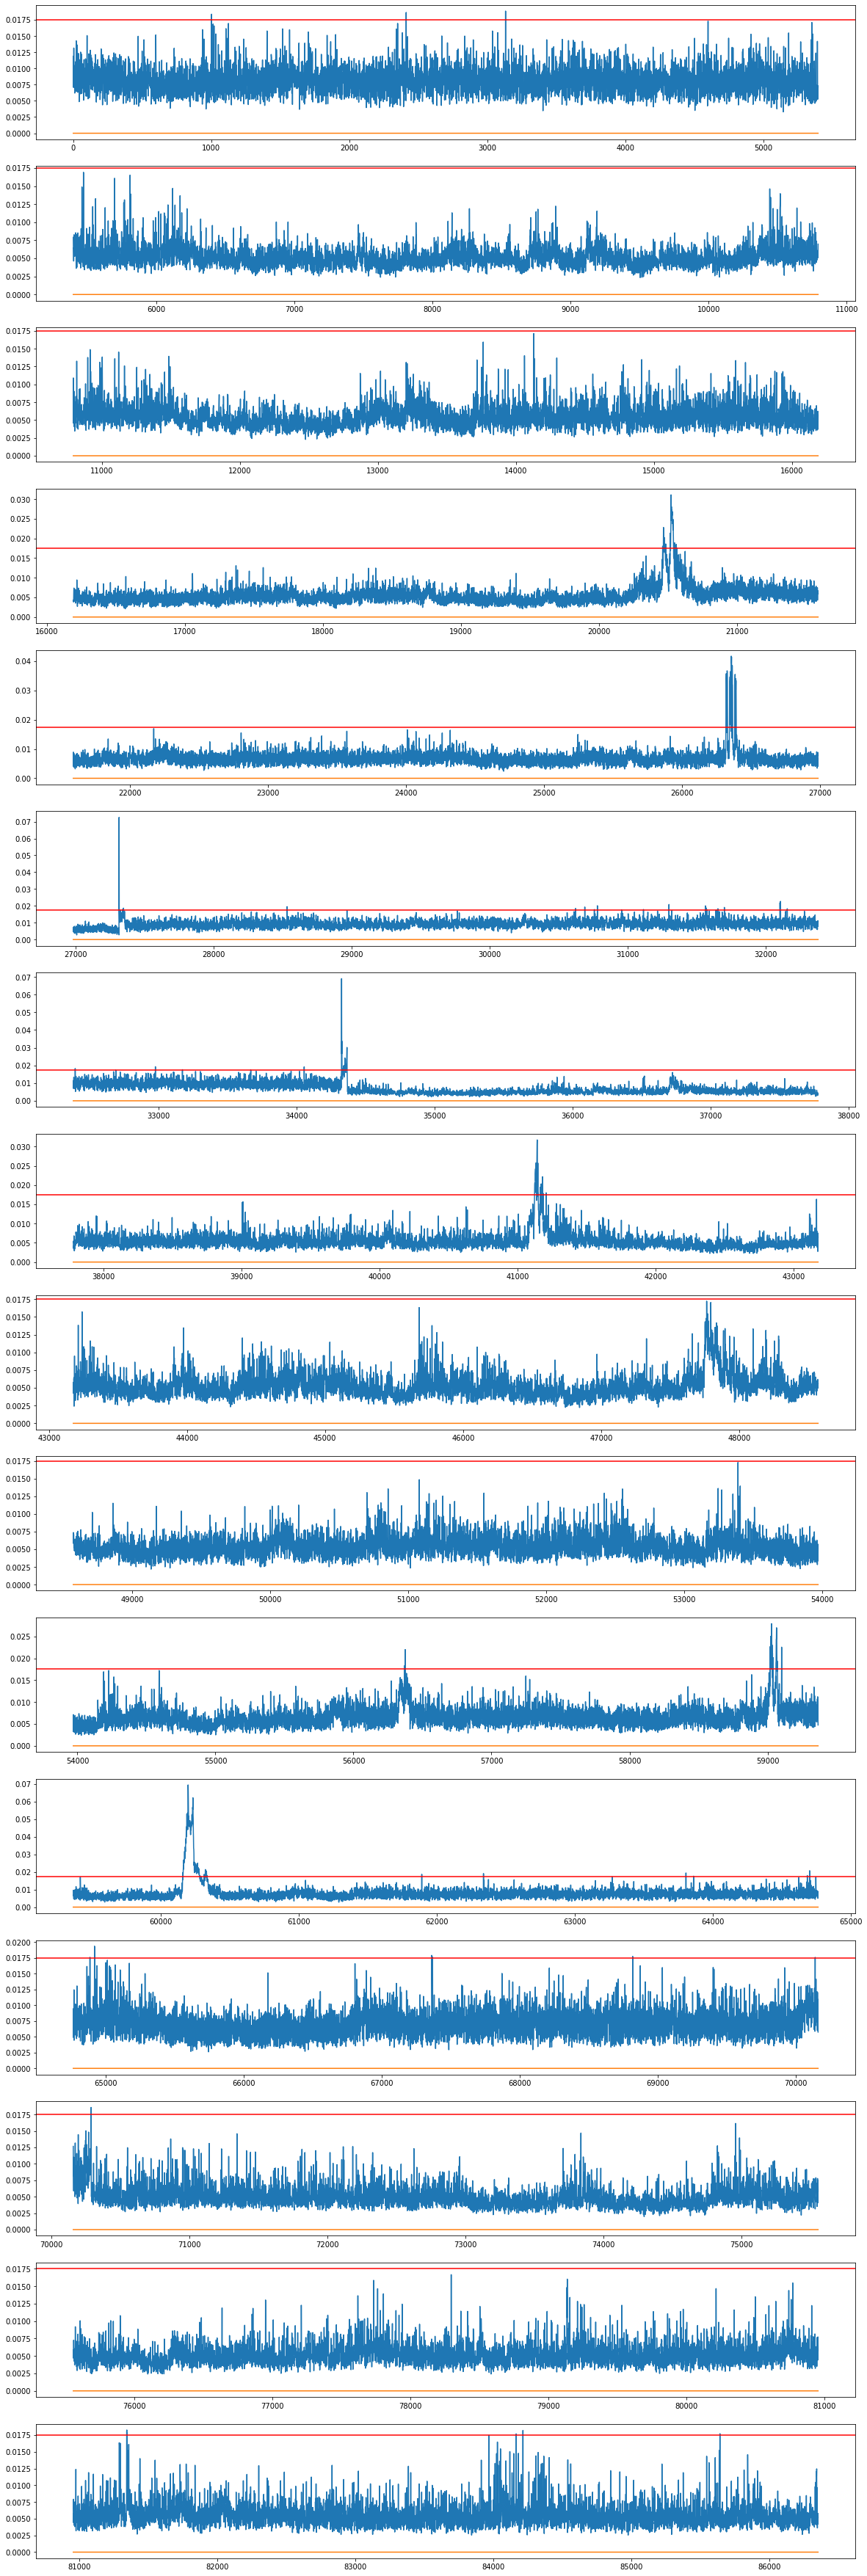

In [118]:
THRESHOLD = 0.0175
check_graph(valid_ANOMALY_SCORE, valid_CHECK_ATT, piece=16, THRESHOLD=THRESHOLD)
# Threshold는 얼마로 지정할지 생각해봐야할듯 해당 수치 넘으면 공격, 아니면 정상
# 주황색 그래프와 빨간색 그래프의 차이를 좁혀나가면서 Threshold를 정해주면됨

In [119]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

    #Threshold보다 distance가 크면 Attack 으로 간주하는 식

In [120]:
LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (86361,))

In [121]:
ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [ ]:
# 탐지 모델 - 윈도우 방식

# 첫 시작의 몇 초는 판단을 내릴 수 없고 (예전 MA 식 만든거 생각해보면됨)
# 데이터셋 불연속 시간 구간 체크 어려움
# 위에서 보시는 바와 같이 정답에 비해 얻어낸 label의 수가 적습니다.



In [76]:
#정상은 0 비정상 1
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [132]:
###### valid_test용 #################
THRESHOLD = 0.0185
LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)

In [159]:
for i in trange(1000):
  THRESHOLD = 0.01801+i*0.00001
  LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
  ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)
  FINAL_LABELS = fill_blank(valid_CHECK_TS, LABELS, np.array(raw_validation['timestamp']))
  TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
  print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f}) Threshold = {THRESHOLD:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

F1: 0.157 (TaP: 0.106, TaR: 0.303) Threshold = 0.01801
F1: 0.157 (TaP: 0.106, TaR: 0.303) Threshold = 0.01802
F1: 0.157 (TaP: 0.106, TaR: 0.302) Threshold = 0.01803
F1: 0.154 (TaP: 0.104, TaR: 0.301) Threshold = 0.01804
F1: 0.154 (TaP: 0.104, TaR: 0.301) Threshold = 0.01805
F1: 0.155 (TaP: 0.104, TaR: 0.300) Threshold = 0.01806
F1: 0.155 (TaP: 0.104, TaR: 0.300) Threshold = 0.01807
F1: 0.155 (TaP: 0.104, TaR: 0.300) Threshold = 0.01808
F1: 0.155 (TaP: 0.104, TaR: 0.297) Threshold = 0.01809
F1: 0.155 (TaP: 0.104, TaR: 0.297) Threshold = 0.01810
F1: 0.155 (TaP: 0.104, TaR: 0.297) Threshold = 0.01811
F1: 0.155 (TaP: 0.105, TaR: 0.297) Threshold = 0.01812
F1: 0.155 (TaP: 0.105, TaR: 0.297) Threshold = 0.01813
F1: 0.155 (TaP: 0.105, TaR: 0.297) Threshold = 0.01814
F1: 0.155 (TaP: 0.105, TaR: 0.297) Threshold = 0.01815
F1: 0.155 (TaP: 0.105, TaR: 0.297) Threshold = 0.01816
F1: 0.155 (TaP: 0.105, TaR: 0.296) Threshold = 0.01817
F1: 0.155 (TaP: 0.105, TaR: 0.296) Threshold = 0.01818
F1: 0.155 

KeyboardInterrupt: ignored

In [160]:
THRESHOLD = 0.01839
LABELS = put_labels(valid_ANOMALY_SCORE, THRESHOLD)
ATTACK_LABELS = put_labels(np.array(raw_validation['attack']), threshold=THRESHOLD)


In [161]:
%%time
FINAL_LABELS = fill_blank(valid_CHECK_TS, LABELS, np.array(raw_validation['timestamp'])) # Labeling 진행
FINAL_LABELS.shape

CPU times: user 15.6 s, sys: 78.9 ms, total: 15.7 s
Wall time: 15.7 s


## 평가

In [162]:
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}") # f1 score로 점수 받기

F1: 0.162 (TaP: 0.112, TaR: 0.292)
# of detected anomalies: 4
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7f6056bd6410>, <TaPR_pkg.DataManage.Range.Range object at 0x7f60564de710>, <TaPR_pkg.DataManage.Range.Range object at 0x7f6056c3ba10>, <TaPR_pkg.DataManage.Range.Range object at 0x7f6075888490>]


In [163]:
boundary_check(df_test)
test_data = HaiDataset(raw_test['timestamp'],df_test, stride=1)

test_data[0]

  0%|          | 0/274761 [00:00<?, ?it/s]

# of valid windows: 274683


{'answer': tensor([0.3283, 0.0000, 0.0798, 0.5049, 0.0900, 0.3598, 0.7118, 0.0000, 0.0000,
         0.0000, 0.3774, 0.3887, 0.3467, 0.2367, 0.5363, 0.2594, 0.0000, 0.0000,
         0.0000, 0.6997, 0.2275, 0.0000, 0.5416, 0.2949, 0.0184, 0.0000, 0.5478,
         0.6075, 0.0000, 0.8326, 0.3982, 0.2597, 0.2600, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0175, 0.2432, 0.5320, 0.4188, 0.4401, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.1611, 0.8307, 0.0000, 0.7381, 0.0081,
         0.0000, 0.5945, 0.3181, 0.1386, 0.2675, 0.5635, 1.0000, 0.7847, 0.0000,
         0.0000, 0.7877, 0.9107, 0.1112, 0.3488, 0.0000, 0.3183, 1.0000, 0.1040,
         0.3382, 0.0728, 0.2539, 0.2619, 0.3860, 0.1703, 0.2852, 0.0726, 0.8706,
         0.0000, 0.3940, 0.0000, 0.0000, 0.0091]),
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4717, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1733],
         [0.4593, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1767],
      

In [164]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(test_data, MODEL, BATCH_SIZE)

CPU times: user 16.4 s, sys: 114 ms, total: 16.5 s
Wall time: 16.4 s


In [165]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

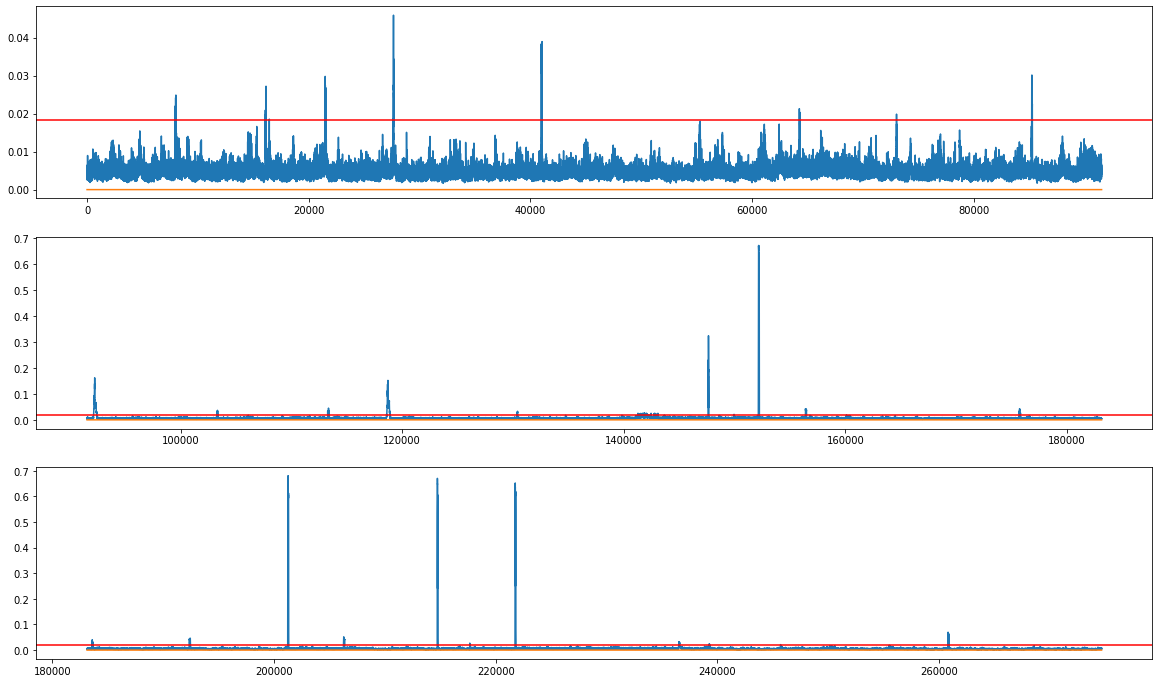

In [166]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [167]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (274683,))

## 저장

In [168]:
submission = pd.read_csv('./gdrive/MyDrive/멋사_study/HAICon2021/HAICon2021_dataset/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [169]:
submission.to_csv('test5_Th_0.1839.csv', index=False)